<a href="https://colab.research.google.com/github/melikeguler99/Applying-RF-Model-to-Single-cell-seq-RNA/blob/main/Ideal_CC_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Preprocessing
mito_genes = ad.var["gene_symbol"].str.startswith('MT-')
ad.obs['percent_mito'] = np.sum(
    100 * ad[:, mito_genes].X, axis=1).A1 / np.sum(ad.X, axis=1).A1

# filter percent_mito < 0.12

ad.obs['n_counts'] = ad.X.sum(axis=1).A1
ad.obs['n_UMIs'] = ad.obs['n_counts'].copy()
ad.obs['n_genes'] = (ad.X > 0).sum(axis=1).A1
ribo_genes =  ad.var["gene_symbol"].str.startswith(("RPS","RPL"))
ad.obs['percent_ribo'] = np.sum(
    100 * ad[:, ribo_genes].X, axis=1).A1 / np.sum(ad.X, axis=1).A1

sc.pl.violin(ad, ['n_genes', 'n_UMIs', 'percent_mito', 'percent_ribo'],
             jitter=0.4, multi_panel=True)
sc.pp.normalize_total(ad, target_sum=1e4)
sc.pp.log1p(ad)

# Set the .raw attribute of AnnData object to the normalized and logarithmizZMed raw gene expression 
# for later use in differential testing and visualizations of gene expression.
ad.raw = ad

# Find highly variable genes
sc.pp.highly_variable_genes(ad)
sc.pl.highly_variable_genes(ad)

# Just keep highly variable genes
ad = ad[:, ad.var.highly_variable]

# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(ad, max_value=10)

# Dimention reduction: PCA as a first step
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# 2D UMAP coordinates on the neighbor graph
sc.tl.umap(ad)

""Random Forest Model""

#By ensuring that the number of samples from each cell type is roughly equal, it reduces the likelihood of the model being biased towards a particular cell type. 
num = len(adata[adata.obs.cell_type.isin(['Endothelial cell', 'Aerocyte'])])
barcodes = random.choices(adata[~adata.obs.cell_type.isin(['Endothelial cell', 'Aerocyte'])].obs.index, k = num)
len(barcodes)
barcodes = barcodes + adata[adata.obs.cell_type.isin(['Endothelial cell', 'Aerocyte'])].obs.index.tolist()
len(barcodes)
train = adata[barcodes]
test = sc.read_h5ad('-----')

var_names = sc.concat((train, test))

var_names = var_names.var_names
test = test[:, var_names]
train = train[:, var_names]

def label_train(x):
    if x == 'Endothelial cell' or x == 'Aerocyte':
        return 1
    else:
        return 0
y = train.obs.cell_type.map(label_train)
sel = RandomForestClassifier(n_estimators=100)
sel.fit(train.X, y)
RandomForestClassifier()
predictions = sel.predict(test.X)
test.obs['predictions'] = predictions

def label_test(x):
    if x in ['endothelial cell of artery', 
             'capillary endothelial cell', 'capillary aerocyte', 
             'vein endothelial cell', 'lung microvascular endothelial cell']:
        return 1
    else:
        return 0

test.obs['labels'] = test.obs.cell_ontology_class.map(label_test)
metrics.accuracy_score(test.obs['labels'], predictions)
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
from matplotlib.pyplot import rc_context

with rc_context({'figure.figsize': (8,8)}):
    sc.pl.umap(test, color = ['labels', 'predictions'], frameon = False, s = 10)

2500 3804
1517 3562


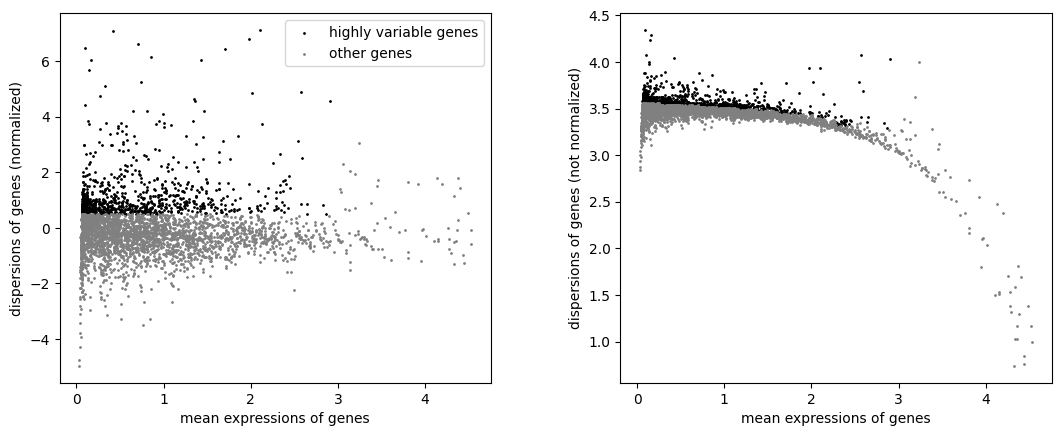

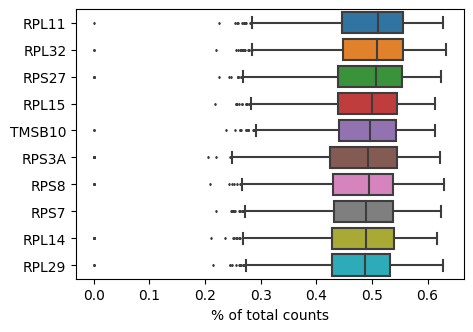

In [69]:
import scanpy as sc
adata = sc.read('updated.h5ad', delimiter='\t')
print(adata.n_obs, adata.n_vars)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
print(adata.n_obs, adata.n_vars)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
sc.pl.highest_expr_genes(adata, n_top=10)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(ad, max_value=10)

# Dimention reduction: PCA as a first step
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)


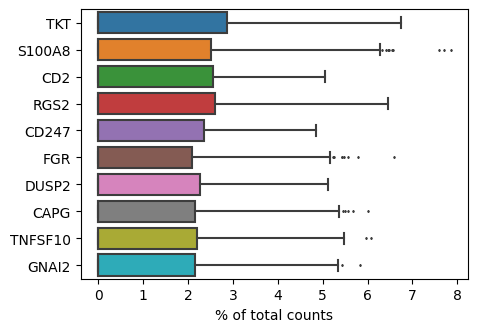

In [61]:
 sc.pl.highest_expr_genes(adata, n_top=10)
 adata = adata[:, adata.var.highly_variable]
 sc.pp.scale(ad, max_value=10)

# Dimention reduction: PCA as a first step
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)


In [ ]:
import pandas as pd
import scanpy as sc

# read in the data.training file as a pandas dataframe
data = pd.read_csv('data.training.txt', sep='\t', index_col=0)
metadata = pd.read_csv('meta.data.training.CellTypes.txt', sep='\t')

# create an AnnData object with the data and metadata
adata = sc.AnnData(X=data.values.T, obs=metadata)

# make the variable names unique
adata.var_names_make_unique()

# set the observation names to be the same as the column names
adata.obs_names = data.columns

# set the variables names to be the same as the row names
adata.var_names = data.index

# write the AnnData object to a file
adata.write('updated_data.training.h5ad')
